### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [5]:
import numpy as np
import os
import torch
import torch.nn as nn
import yaml
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter


### Downloading the dataset


In [6]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


### Dataset inspection

In [7]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [8]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


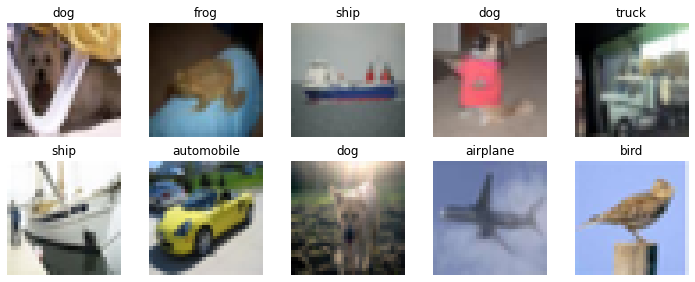

In [9]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


In [10]:
# Spliting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### Dataloaders

In [17]:
training_config = {'BATCH_SIZE' : 1024,
                   'lr' : 5e-5,
                   'epochs' : 200,
                   'Experiment_name': 'Exp1'
                   }


train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False
)

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )

## MLP

In [18]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=1024, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [19]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = Model().to(device)

summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                   [-1, 10]          10,250
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 12.04
Estimated Total Size (MB): 12.07
----------------------------------------------------------------


In [20]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=training_config['lr'])

In [21]:
# Checkpoints directory
root = Path("./")
Experiment = training_config['Experiment_name']
save_dir = root/'models'/Experiment
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

# Save the training configuration for each experiment
with open(os.path.join(save_dir, "training_config.yaml"), "w") as f:
    yaml.dump(training_config, f)


In [24]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

# Tensorboard log directory
log_dir = root/'log_dir'
log_dir = os.path.join(log_dir, Experiment)

# Initialize TensorBoard
writer = SummaryWriter(log_dir=log_dir)  

print("##### TRAINING ... ####")
for epoch in range(training_config['epochs']):
    mlp_model.train()
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        loss = criterion(preds, labels)
        log_dict['Training_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss.item():.5f}. ")

        writer.add_scalar('Loss/train', loss.item())

    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        mlp_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_imgs, val_labels in val_loader:
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                flattened_val_imgs = val_imgs.flatten(start_dim=1)
                val_preds = mlp_model(flattened_val_imgs)
                val_loss += criterion(val_preds, val_labels).item()
        
        avg_val_loss = val_loss / len(eval_loader)
        writer.add_scalar('Loss/val', avg_val_loss)
        log_dict['Validation_loss'].append(avg_val_loss)
        print(f"\nValidation loss after epoch {epoch + 1}: {avg_val_loss:.5f}")

writer.close()


##### TRAINING ... ####


Epoch 1 Batch 40: loss 1.77156. : 100%|██████████| 40/40 [00:01<00:00, 26.15it/s]



Validation loss after epoch 1: 1.81639


Epoch 2 Batch 40: loss 1.49230. : 100%|██████████| 40/40 [00:01<00:00, 26.89it/s]



Validation loss after epoch 2: 1.81639


Epoch 3 Batch 40: loss 1.60653. : 100%|██████████| 40/40 [00:01<00:00, 27.18it/s]



Validation loss after epoch 3: 1.81639


Epoch 4 Batch 40: loss 1.61008. : 100%|██████████| 40/40 [00:01<00:00, 26.62it/s]



Validation loss after epoch 4: 1.81639


Epoch 5 Batch 40: loss 1.59543. : 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]



Validation loss after epoch 5: 1.77908


Epoch 6 Batch 40: loss 1.45032. : 100%|██████████| 40/40 [00:01<00:00, 27.40it/s]



Validation loss after epoch 6: 1.77908


Epoch 7 Batch 40: loss 1.41578. : 100%|██████████| 40/40 [00:01<00:00, 27.22it/s]



Validation loss after epoch 7: 1.77908


Epoch 8 Batch 40: loss 1.38456. : 100%|██████████| 40/40 [00:01<00:00, 26.73it/s]



Validation loss after epoch 8: 1.77908


Epoch 9 Batch 40: loss 1.77700. : 100%|██████████| 40/40 [00:01<00:00, 26.92it/s]



Validation loss after epoch 9: 1.77908


Epoch 10 Batch 40: loss 1.41601. : 100%|██████████| 40/40 [00:01<00:00, 27.34it/s]



Validation loss after epoch 10: 1.75147


Epoch 11 Batch 40: loss 1.36788. : 100%|██████████| 40/40 [00:01<00:00, 27.30it/s]



Validation loss after epoch 11: 1.75147


Epoch 12 Batch 40: loss 1.33373. : 100%|██████████| 40/40 [00:01<00:00, 26.61it/s]



Validation loss after epoch 12: 1.75147


Epoch 13 Batch 40: loss 1.55519. : 100%|██████████| 40/40 [00:01<00:00, 26.92it/s]



Validation loss after epoch 13: 1.75147


Epoch 14 Batch 40: loss 1.62616. : 100%|██████████| 40/40 [00:01<00:00, 26.11it/s]



Validation loss after epoch 14: 1.75147


Epoch 15 Batch 40: loss 1.41637. : 100%|██████████| 40/40 [00:01<00:00, 26.90it/s]



Validation loss after epoch 15: 1.72869


Epoch 16 Batch 40: loss 1.49047. : 100%|██████████| 40/40 [00:01<00:00, 27.34it/s]



Validation loss after epoch 16: 1.72869


Epoch 17 Batch 40: loss 1.51053. : 100%|██████████| 40/40 [00:01<00:00, 27.01it/s]



Validation loss after epoch 17: 1.72869


Epoch 18 Batch 40: loss 1.52873. : 100%|██████████| 40/40 [00:01<00:00, 27.36it/s]



Validation loss after epoch 18: 1.72869


Epoch 19 Batch 40: loss 1.34541. : 100%|██████████| 40/40 [00:01<00:00, 26.69it/s]



Validation loss after epoch 19: 1.72869


Epoch 20 Batch 40: loss 1.24011. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 20: 1.69980


Epoch 21 Batch 40: loss 1.49385. : 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]



Validation loss after epoch 21: 1.69980


Epoch 22 Batch 40: loss 1.62689. : 100%|██████████| 40/40 [00:01<00:00, 26.48it/s]



Validation loss after epoch 22: 1.69980


Epoch 23 Batch 40: loss 1.48270. : 100%|██████████| 40/40 [00:01<00:00, 27.10it/s]



Validation loss after epoch 23: 1.69980


Epoch 24 Batch 40: loss 1.57113. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 24: 1.69980


Epoch 25 Batch 40: loss 1.43837. : 100%|██████████| 40/40 [00:01<00:00, 27.05it/s]



Validation loss after epoch 25: 1.68306


Epoch 26 Batch 40: loss 1.34297. : 100%|██████████| 40/40 [00:01<00:00, 27.17it/s]



Validation loss after epoch 26: 1.68306


Epoch 27 Batch 40: loss 1.33859. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 27: 1.68306


Epoch 28 Batch 40: loss 1.41455. : 100%|██████████| 40/40 [00:01<00:00, 27.15it/s]



Validation loss after epoch 28: 1.68306


Epoch 29 Batch 40: loss 1.36118. : 100%|██████████| 40/40 [00:01<00:00, 26.99it/s]



Validation loss after epoch 29: 1.68306


Epoch 30 Batch 40: loss 1.42995. : 100%|██████████| 40/40 [00:01<00:00, 26.74it/s]



Validation loss after epoch 30: 1.66950


Epoch 31 Batch 40: loss 1.41466. : 100%|██████████| 40/40 [00:01<00:00, 27.01it/s]



Validation loss after epoch 31: 1.66950


Epoch 32 Batch 40: loss 1.39586. : 100%|██████████| 40/40 [00:01<00:00, 27.24it/s]



Validation loss after epoch 32: 1.66950


Epoch 33 Batch 40: loss 1.48523. : 100%|██████████| 40/40 [00:01<00:00, 26.39it/s]



Validation loss after epoch 33: 1.66950


Epoch 34 Batch 40: loss 1.31447. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 34: 1.66950


Epoch 35 Batch 40: loss 1.36810. : 100%|██████████| 40/40 [00:01<00:00, 27.13it/s]



Validation loss after epoch 35: 1.64677


Epoch 36 Batch 40: loss 1.26265. : 100%|██████████| 40/40 [00:01<00:00, 27.11it/s]



Validation loss after epoch 36: 1.64677


Epoch 37 Batch 40: loss 1.54149. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 37: 1.64677


Epoch 38 Batch 40: loss 1.50464. : 100%|██████████| 40/40 [00:01<00:00, 26.53it/s]



Validation loss after epoch 38: 1.64677


Epoch 39 Batch 40: loss 1.21446. : 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]



Validation loss after epoch 39: 1.64677


Epoch 40 Batch 40: loss 1.42040. : 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]



Validation loss after epoch 40: 1.63642


Epoch 41 Batch 40: loss 1.28582. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 41: 1.63642


Epoch 42 Batch 40: loss 1.35916. : 100%|██████████| 40/40 [00:01<00:00, 27.17it/s]



Validation loss after epoch 42: 1.63642


Epoch 43 Batch 40: loss 1.34064. : 100%|██████████| 40/40 [00:01<00:00, 27.20it/s]



Validation loss after epoch 43: 1.63642


Epoch 44 Batch 40: loss 1.45793. : 100%|██████████| 40/40 [00:01<00:00, 27.17it/s]



Validation loss after epoch 44: 1.63642


Epoch 45 Batch 40: loss 1.34809. : 100%|██████████| 40/40 [00:01<00:00, 26.65it/s]



Validation loss after epoch 45: 1.62607


Epoch 46 Batch 40: loss 1.28007. : 100%|██████████| 40/40 [00:01<00:00, 27.20it/s]



Validation loss after epoch 46: 1.62607


Epoch 47 Batch 40: loss 1.38512. : 100%|██████████| 40/40 [00:01<00:00, 27.02it/s]



Validation loss after epoch 47: 1.62607


Epoch 48 Batch 40: loss 1.41452. : 100%|██████████| 40/40 [00:01<00:00, 27.32it/s]



Validation loss after epoch 48: 1.62607


Epoch 49 Batch 40: loss 1.65398. : 100%|██████████| 40/40 [00:01<00:00, 26.27it/s]



Validation loss after epoch 49: 1.62607


Epoch 50 Batch 40: loss 1.28595. : 100%|██████████| 40/40 [00:01<00:00, 27.26it/s]



Validation loss after epoch 50: 1.60842


Epoch 51 Batch 40: loss 1.37637. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 51: 1.60842


Epoch 52 Batch 40: loss 1.30015. : 100%|██████████| 40/40 [00:01<00:00, 26.67it/s]



Validation loss after epoch 52: 1.60842


Epoch 53 Batch 40: loss 1.45932. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 53: 1.60842


Epoch 54 Batch 40: loss 1.37348. : 100%|██████████| 40/40 [00:01<00:00, 26.86it/s]



Validation loss after epoch 54: 1.60842


Epoch 55 Batch 40: loss 1.32389. : 100%|██████████| 40/40 [00:01<00:00, 27.29it/s]



Validation loss after epoch 55: 1.59755


Epoch 56 Batch 40: loss 1.06414. : 100%|██████████| 40/40 [00:01<00:00, 26.56it/s]



Validation loss after epoch 56: 1.59755


Epoch 57 Batch 40: loss 1.45893. : 100%|██████████| 40/40 [00:01<00:00, 27.27it/s]



Validation loss after epoch 57: 1.59755


Epoch 58 Batch 40: loss 1.06187. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 58: 1.59755


Epoch 59 Batch 40: loss 1.41413. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 59: 1.59755


Epoch 60 Batch 40: loss 1.31998. : 100%|██████████| 40/40 [00:01<00:00, 27.10it/s]



Validation loss after epoch 60: 1.59465


Epoch 61 Batch 40: loss 1.33095. : 100%|██████████| 40/40 [00:01<00:00, 26.82it/s]



Validation loss after epoch 61: 1.59465


Epoch 62 Batch 40: loss 1.17786. : 100%|██████████| 40/40 [00:01<00:00, 27.11it/s]



Validation loss after epoch 62: 1.59465


Epoch 63 Batch 40: loss 1.33053. : 100%|██████████| 40/40 [00:01<00:00, 27.03it/s]



Validation loss after epoch 63: 1.59465


Epoch 64 Batch 40: loss 1.38980. : 100%|██████████| 40/40 [00:01<00:00, 26.34it/s]



Validation loss after epoch 64: 1.59465


Epoch 65 Batch 40: loss 1.30730. : 100%|██████████| 40/40 [00:01<00:00, 26.76it/s]



Validation loss after epoch 65: 1.58449


Epoch 66 Batch 40: loss 1.43347. : 100%|██████████| 40/40 [00:01<00:00, 27.28it/s]



Validation loss after epoch 66: 1.58449


Epoch 67 Batch 40: loss 1.33440. : 100%|██████████| 40/40 [00:01<00:00, 26.63it/s]



Validation loss after epoch 67: 1.58449


Epoch 68 Batch 40: loss 1.30002. : 100%|██████████| 40/40 [00:01<00:00, 27.26it/s]



Validation loss after epoch 68: 1.58449


Epoch 69 Batch 40: loss 1.31303. : 100%|██████████| 40/40 [00:01<00:00, 27.31it/s]



Validation loss after epoch 69: 1.58449


Epoch 70 Batch 40: loss 1.22163. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 70: 1.57300


Epoch 71 Batch 40: loss 1.27929. : 100%|██████████| 40/40 [00:01<00:00, 27.27it/s]



Validation loss after epoch 71: 1.57300


Epoch 72 Batch 40: loss 1.17336. : 100%|██████████| 40/40 [00:01<00:00, 26.77it/s]



Validation loss after epoch 72: 1.57300


Epoch 73 Batch 40: loss 1.24220. : 100%|██████████| 40/40 [00:01<00:00, 27.17it/s]



Validation loss after epoch 73: 1.57300


Epoch 74 Batch 40: loss 1.34874. : 100%|██████████| 40/40 [00:01<00:00, 27.36it/s]



Validation loss after epoch 74: 1.57300


Epoch 75 Batch 40: loss 1.48164. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 75: 1.57084


Epoch 76 Batch 40: loss 1.07964. : 100%|██████████| 40/40 [00:01<00:00, 26.80it/s]



Validation loss after epoch 76: 1.57084


Epoch 77 Batch 40: loss 1.26296. : 100%|██████████| 40/40 [00:01<00:00, 27.10it/s]



Validation loss after epoch 77: 1.57084


Epoch 78 Batch 40: loss 1.60251. : 100%|██████████| 40/40 [00:01<00:00, 27.02it/s]



Validation loss after epoch 78: 1.57084


Epoch 79 Batch 40: loss 1.29025. : 100%|██████████| 40/40 [00:01<00:00, 27.25it/s]



Validation loss after epoch 79: 1.57084


Epoch 80 Batch 40: loss 1.06394. : 100%|██████████| 40/40 [00:01<00:00, 27.22it/s]



Validation loss after epoch 80: 1.55687


Epoch 81 Batch 40: loss 1.17099. : 100%|██████████| 40/40 [00:01<00:00, 26.73it/s]



Validation loss after epoch 81: 1.55687


Epoch 82 Batch 40: loss 1.24648. : 100%|██████████| 40/40 [00:01<00:00, 27.22it/s]



Validation loss after epoch 82: 1.55687


Epoch 83 Batch 40: loss 1.31462. : 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]



Validation loss after epoch 83: 1.55687


Epoch 84 Batch 40: loss 1.40336. : 100%|██████████| 40/40 [00:01<00:00, 26.60it/s]



Validation loss after epoch 84: 1.55687


Epoch 85 Batch 40: loss 1.12767. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 85: 1.55292


Epoch 86 Batch 40: loss 1.34527. : 100%|██████████| 40/40 [00:01<00:00, 27.18it/s]



Validation loss after epoch 86: 1.55292


Epoch 87 Batch 40: loss 1.05839. : 100%|██████████| 40/40 [00:01<00:00, 26.66it/s]



Validation loss after epoch 87: 1.55292


Epoch 88 Batch 40: loss 1.39950. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 88: 1.55292


Epoch 89 Batch 40: loss 1.24046. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 89: 1.55292


Epoch 90 Batch 40: loss 1.23347. : 100%|██████████| 40/40 [00:01<00:00, 27.18it/s]



Validation loss after epoch 90: 1.54851


Epoch 91 Batch 40: loss 1.19031. : 100%|██████████| 40/40 [00:01<00:00, 27.26it/s]



Validation loss after epoch 91: 1.54851


Epoch 92 Batch 40: loss 1.01356. : 100%|██████████| 40/40 [00:01<00:00, 26.69it/s]



Validation loss after epoch 92: 1.54851


Epoch 93 Batch 40: loss 1.35664. : 100%|██████████| 40/40 [00:01<00:00, 26.85it/s]



Validation loss after epoch 93: 1.54851


Epoch 94 Batch 40: loss 1.11061. : 100%|██████████| 40/40 [00:01<00:00, 27.08it/s]



Validation loss after epoch 94: 1.54851


Epoch 95 Batch 40: loss 1.46947. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 95: 1.54135


Epoch 96 Batch 40: loss 1.12880. : 100%|██████████| 40/40 [00:01<00:00, 26.16it/s]



Validation loss after epoch 96: 1.54135


Epoch 97 Batch 40: loss 1.14844. : 100%|██████████| 40/40 [00:01<00:00, 27.10it/s]



Validation loss after epoch 97: 1.54135


Epoch 98 Batch 40: loss 1.43017. : 100%|██████████| 40/40 [00:01<00:00, 27.08it/s]



Validation loss after epoch 98: 1.54135


Epoch 99 Batch 40: loss 1.36633. : 100%|██████████| 40/40 [00:01<00:00, 27.10it/s]



Validation loss after epoch 99: 1.54135


Epoch 100 Batch 40: loss 1.27320. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 100: 1.54548


Epoch 101 Batch 40: loss 1.33755. : 100%|██████████| 40/40 [00:01<00:00, 26.63it/s]



Validation loss after epoch 101: 1.54548


Epoch 102 Batch 40: loss 1.38407. : 100%|██████████| 40/40 [00:01<00:00, 26.58it/s]



Validation loss after epoch 102: 1.54548


Epoch 103 Batch 40: loss 1.22264. : 100%|██████████| 40/40 [00:01<00:00, 27.01it/s]



Validation loss after epoch 103: 1.54548


Epoch 104 Batch 40: loss 1.13236. : 100%|██████████| 40/40 [00:01<00:00, 26.54it/s]



Validation loss after epoch 104: 1.54548


Epoch 105 Batch 40: loss 1.10083. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 105: 1.53031


Epoch 106 Batch 40: loss 1.24689. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 106: 1.53031


Epoch 107 Batch 40: loss 1.10604. : 100%|██████████| 40/40 [00:01<00:00, 26.44it/s]



Validation loss after epoch 107: 1.53031


Epoch 108 Batch 40: loss 1.15667. : 100%|██████████| 40/40 [00:01<00:00, 27.04it/s]



Validation loss after epoch 108: 1.53031


Epoch 109 Batch 40: loss 1.12379. : 100%|██████████| 40/40 [00:01<00:00, 26.97it/s]



Validation loss after epoch 109: 1.53031


Epoch 110 Batch 40: loss 1.07930. : 100%|██████████| 40/40 [00:01<00:00, 26.94it/s]



Validation loss after epoch 110: 1.51916


Epoch 111 Batch 40: loss 1.30013. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 111: 1.51916


Epoch 112 Batch 40: loss 1.19566. : 100%|██████████| 40/40 [00:01<00:00, 26.45it/s]



Validation loss after epoch 112: 1.51916


Epoch 113 Batch 40: loss 1.06250. : 100%|██████████| 40/40 [00:01<00:00, 26.77it/s]



Validation loss after epoch 113: 1.51916


Epoch 114 Batch 40: loss 1.18927. : 100%|██████████| 40/40 [00:01<00:00, 27.11it/s]



Validation loss after epoch 114: 1.51916


Epoch 115 Batch 40: loss 0.95472. : 100%|██████████| 40/40 [00:01<00:00, 27.20it/s]



Validation loss after epoch 115: 1.52445


Epoch 116 Batch 40: loss 1.04394. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 116: 1.52445


Epoch 117 Batch 40: loss 0.95824. : 100%|██████████| 40/40 [00:01<00:00, 27.40it/s]



Validation loss after epoch 117: 1.52445


Epoch 118 Batch 40: loss 1.35886. : 100%|██████████| 40/40 [00:01<00:00, 27.11it/s]



Validation loss after epoch 118: 1.52445


Epoch 119 Batch 40: loss 1.21022. : 100%|██████████| 40/40 [00:01<00:00, 26.85it/s]



Validation loss after epoch 119: 1.52445


Epoch 120 Batch 40: loss 1.31429. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 120: 1.51111


Epoch 121 Batch 40: loss 1.34217. : 100%|██████████| 40/40 [00:01<00:00, 26.58it/s]



Validation loss after epoch 121: 1.51111


Epoch 122 Batch 40: loss 1.24955. : 100%|██████████| 40/40 [00:01<00:00, 26.98it/s]



Validation loss after epoch 122: 1.51111


Epoch 123 Batch 40: loss 1.00365. : 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]



Validation loss after epoch 123: 1.51111


Epoch 124 Batch 40: loss 1.26019. : 100%|██████████| 40/40 [00:01<00:00, 26.11it/s]



Validation loss after epoch 124: 1.51111


Epoch 125 Batch 40: loss 1.06620. : 100%|██████████| 40/40 [00:01<00:00, 27.17it/s]



Validation loss after epoch 125: 1.51437


Epoch 126 Batch 40: loss 0.97429. : 100%|██████████| 40/40 [00:01<00:00, 27.37it/s]



Validation loss after epoch 126: 1.51437


Epoch 127 Batch 40: loss 1.02672. : 100%|██████████| 40/40 [00:01<00:00, 27.30it/s]



Validation loss after epoch 127: 1.51437


Epoch 128 Batch 40: loss 1.44266. : 100%|██████████| 40/40 [00:01<00:00, 26.71it/s]



Validation loss after epoch 128: 1.51437


Epoch 129 Batch 40: loss 0.99034. : 100%|██████████| 40/40 [00:01<00:00, 26.62it/s]



Validation loss after epoch 129: 1.51437


Epoch 130 Batch 40: loss 1.14961. : 100%|██████████| 40/40 [00:01<00:00, 26.78it/s]



Validation loss after epoch 130: 1.52036


Epoch 131 Batch 40: loss 1.21343. : 100%|██████████| 40/40 [00:01<00:00, 27.16it/s]



Validation loss after epoch 131: 1.52036


Epoch 132 Batch 40: loss 1.18206. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 132: 1.52036


Epoch 133 Batch 40: loss 1.35762. : 100%|██████████| 40/40 [00:01<00:00, 27.26it/s]



Validation loss after epoch 133: 1.52036


Epoch 134 Batch 40: loss 1.05528. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 134: 1.52036


Epoch 135 Batch 40: loss 1.10587. : 100%|██████████| 40/40 [00:01<00:00, 27.27it/s]



Validation loss after epoch 135: 1.50208


Epoch 136 Batch 40: loss 1.08625. : 100%|██████████| 40/40 [00:01<00:00, 27.28it/s]



Validation loss after epoch 136: 1.50208


Epoch 137 Batch 40: loss 1.23254. : 100%|██████████| 40/40 [00:01<00:00, 26.71it/s]



Validation loss after epoch 137: 1.50208


Epoch 138 Batch 40: loss 1.10878. : 100%|██████████| 40/40 [00:01<00:00, 27.13it/s]



Validation loss after epoch 138: 1.50208


Epoch 139 Batch 40: loss 1.13656. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 139: 1.50208


Epoch 140 Batch 40: loss 1.03291. : 100%|██████████| 40/40 [00:01<00:00, 26.98it/s]



Validation loss after epoch 140: 1.50334


Epoch 141 Batch 40: loss 1.10025. : 100%|██████████| 40/40 [00:01<00:00, 27.31it/s]



Validation loss after epoch 141: 1.50334


Epoch 142 Batch 40: loss 1.23686. : 100%|██████████| 40/40 [00:01<00:00, 26.67it/s]



Validation loss after epoch 142: 1.50334


Epoch 143 Batch 40: loss 1.33860. : 100%|██████████| 40/40 [00:01<00:00, 27.04it/s]



Validation loss after epoch 143: 1.50334


Epoch 144 Batch 40: loss 1.09761. : 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]



Validation loss after epoch 144: 1.50334


Epoch 145 Batch 40: loss 1.13906. : 100%|██████████| 40/40 [00:01<00:00, 26.54it/s]



Validation loss after epoch 145: 1.50637


Epoch 146 Batch 40: loss 1.22653. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 146: 1.50637


Epoch 147 Batch 40: loss 1.11283. : 100%|██████████| 40/40 [00:01<00:00, 27.37it/s]



Validation loss after epoch 147: 1.50637


Epoch 148 Batch 40: loss 1.30607. : 100%|██████████| 40/40 [00:01<00:00, 27.32it/s]



Validation loss after epoch 148: 1.50637


Epoch 149 Batch 40: loss 0.96128. : 100%|██████████| 40/40 [00:01<00:00, 26.63it/s]



Validation loss after epoch 149: 1.50637


Epoch 150 Batch 40: loss 1.06772. : 100%|██████████| 40/40 [00:01<00:00, 27.13it/s]



Validation loss after epoch 150: 1.49699


Epoch 151 Batch 40: loss 1.16318. : 100%|██████████| 40/40 [00:01<00:00, 27.25it/s]



Validation loss after epoch 151: 1.49699


Epoch 152 Batch 40: loss 0.81885. : 100%|██████████| 40/40 [00:01<00:00, 27.03it/s]



Validation loss after epoch 152: 1.49699


Epoch 153 Batch 40: loss 1.10571. : 100%|██████████| 40/40 [00:01<00:00, 26.45it/s]



Validation loss after epoch 153: 1.49699


Epoch 154 Batch 40: loss 1.19134. : 100%|██████████| 40/40 [00:01<00:00, 27.06it/s]



Validation loss after epoch 154: 1.49699


Epoch 155 Batch 40: loss 0.97593. : 100%|██████████| 40/40 [00:01<00:00, 27.18it/s]



Validation loss after epoch 155: 1.50289


Epoch 156 Batch 40: loss 1.28694. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 156: 1.50289


Epoch 157 Batch 40: loss 1.15029. : 100%|██████████| 40/40 [00:01<00:00, 27.21it/s]



Validation loss after epoch 157: 1.50289


Epoch 158 Batch 40: loss 0.89725. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 158: 1.50289


Epoch 159 Batch 40: loss 1.22975. : 100%|██████████| 40/40 [00:01<00:00, 27.00it/s]



Validation loss after epoch 159: 1.50289


Epoch 160 Batch 40: loss 1.08882. : 100%|██████████| 40/40 [00:01<00:00, 26.47it/s]



Validation loss after epoch 160: 1.48642


Epoch 161 Batch 40: loss 1.24026. : 100%|██████████| 40/40 [00:01<00:00, 27.07it/s]



Validation loss after epoch 161: 1.48642


Epoch 162 Batch 40: loss 0.93494. : 100%|██████████| 40/40 [00:01<00:00, 26.99it/s]



Validation loss after epoch 162: 1.48642


Epoch 163 Batch 40: loss 0.96076. : 100%|██████████| 40/40 [00:01<00:00, 27.04it/s]



Validation loss after epoch 163: 1.48642


Epoch 164 Batch 40: loss 1.05163. : 100%|██████████| 40/40 [00:01<00:00, 26.64it/s]



Validation loss after epoch 164: 1.48642


Epoch 165 Batch 40: loss 0.93759. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 165: 1.48391


Epoch 166 Batch 40: loss 1.13238. : 100%|██████████| 40/40 [00:01<00:00, 27.31it/s]



Validation loss after epoch 166: 1.48391


Epoch 167 Batch 40: loss 0.87925. : 100%|██████████| 40/40 [00:01<00:00, 26.70it/s]



Validation loss after epoch 167: 1.48391


Epoch 168 Batch 40: loss 1.04370. : 100%|██████████| 40/40 [00:01<00:00, 27.34it/s]



Validation loss after epoch 168: 1.48391


Epoch 169 Batch 40: loss 1.02614. : 100%|██████████| 40/40 [00:01<00:00, 27.29it/s]



Validation loss after epoch 169: 1.48391


Epoch 170 Batch 40: loss 1.15355. : 100%|██████████| 40/40 [00:01<00:00, 27.05it/s]



Validation loss after epoch 170: 1.48098


Epoch 171 Batch 40: loss 1.27466. : 100%|██████████| 40/40 [00:01<00:00, 26.55it/s]



Validation loss after epoch 171: 1.48098


Epoch 172 Batch 40: loss 1.00553. : 100%|██████████| 40/40 [00:01<00:00, 27.19it/s]



Validation loss after epoch 172: 1.48098


Epoch 173 Batch 40: loss 1.02014. : 100%|██████████| 40/40 [00:01<00:00, 27.04it/s]



Validation loss after epoch 173: 1.48098


Epoch 174 Batch 40: loss 1.16641. : 100%|██████████| 40/40 [00:01<00:00, 27.37it/s]



Validation loss after epoch 174: 1.48098


Epoch 175 Batch 40: loss 0.88148. : 100%|██████████| 40/40 [00:01<00:00, 26.86it/s]



Validation loss after epoch 175: 1.49365


Epoch 176 Batch 40: loss 1.08579. : 100%|██████████| 40/40 [00:01<00:00, 26.36it/s]



Validation loss after epoch 176: 1.49365


Epoch 177 Batch 40: loss 1.08998. : 100%|██████████| 40/40 [00:01<00:00, 27.04it/s]



Validation loss after epoch 177: 1.49365


Epoch 178 Batch 40: loss 1.01467. : 100%|██████████| 40/40 [00:01<00:00, 26.94it/s]



Validation loss after epoch 178: 1.49365


Epoch 179 Batch 40: loss 1.15005. : 100%|██████████| 40/40 [00:01<00:00, 26.23it/s]



Validation loss after epoch 179: 1.49365


Epoch 180 Batch 40: loss 1.17593. : 100%|██████████| 40/40 [00:01<00:00, 26.98it/s]



Validation loss after epoch 180: 1.47326


Epoch 181 Batch 40: loss 1.11823. : 100%|██████████| 40/40 [00:01<00:00, 27.28it/s]



Validation loss after epoch 181: 1.47326


Epoch 182 Batch 40: loss 0.97723. : 100%|██████████| 40/40 [00:01<00:00, 26.68it/s]



Validation loss after epoch 182: 1.47326


Epoch 183 Batch 40: loss 1.01719. : 100%|██████████| 40/40 [00:01<00:00, 27.09it/s]



Validation loss after epoch 183: 1.47326


Epoch 184 Batch 40: loss 0.90551. : 100%|██████████| 40/40 [00:01<00:00, 27.07it/s]



Validation loss after epoch 184: 1.47326


Epoch 185 Batch 40: loss 1.00483. : 100%|██████████| 40/40 [00:01<00:00, 27.13it/s]



Validation loss after epoch 185: 1.47674


Epoch 186 Batch 40: loss 1.07961. : 100%|██████████| 40/40 [00:01<00:00, 27.34it/s]



Validation loss after epoch 186: 1.47674


Epoch 187 Batch 40: loss 1.03085. : 100%|██████████| 40/40 [00:01<00:00, 26.75it/s]



Validation loss after epoch 187: 1.47674


Epoch 188 Batch 40: loss 1.03781. : 100%|██████████| 40/40 [00:01<00:00, 27.15it/s]



Validation loss after epoch 188: 1.47674


Epoch 189 Batch 40: loss 1.29344. : 100%|██████████| 40/40 [00:01<00:00, 27.20it/s]



Validation loss after epoch 189: 1.47674


Epoch 190 Batch 40: loss 1.05614. : 100%|██████████| 40/40 [00:01<00:00, 27.26it/s]



Validation loss after epoch 190: 1.47364


Epoch 191 Batch 40: loss 0.92096. : 100%|██████████| 40/40 [00:01<00:00, 26.60it/s]



Validation loss after epoch 191: 1.47364


Epoch 192 Batch 40: loss 0.90768. : 100%|██████████| 40/40 [00:01<00:00, 26.38it/s]



Validation loss after epoch 192: 1.47364


Epoch 193 Batch 40: loss 0.85462. : 100%|██████████| 40/40 [00:01<00:00, 27.01it/s]



Validation loss after epoch 193: 1.47364


Epoch 194 Batch 40: loss 1.04514. : 100%|██████████| 40/40 [00:01<00:00, 27.30it/s]



Validation loss after epoch 194: 1.47364


Epoch 195 Batch 40: loss 1.13844. : 100%|██████████| 40/40 [00:01<00:00, 27.12it/s]



Validation loss after epoch 195: 1.47469


Epoch 196 Batch 40: loss 0.89406. : 100%|██████████| 40/40 [00:01<00:00, 26.74it/s]



Validation loss after epoch 196: 1.47469


Epoch 197 Batch 40: loss 0.83500. : 100%|██████████| 40/40 [00:01<00:00, 27.32it/s]



Validation loss after epoch 197: 1.47469


Epoch 198 Batch 40: loss 1.11633. : 100%|██████████| 40/40 [00:01<00:00, 27.20it/s]



Validation loss after epoch 198: 1.47469


Epoch 199 Batch 40: loss 0.94519. : 100%|██████████| 40/40 [00:01<00:00, 26.56it/s]



Validation loss after epoch 199: 1.47469


Epoch 200 Batch 40: loss 1.13524. : 100%|██████████| 40/40 [00:01<00:00, 26.59it/s]



Validation loss after epoch 200: 1.48046


### EVALUATION

In [25]:

print("##### EVALUATION ... ####")
mlp_model.eval()
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        imgs, labels = imgs.to(device), labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%") 

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 27.79it/s]

Test accuracy: 49.04%


### Saving the model

In [34]:
if(not os.path.exists("models")):
    os.makedirs("models",exist_ok=True)
savepath = f"models/checkpoint_{training_config['Experiment_name']}.pth"

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)